In [ ]:
def timing_bars(run_timing_list,motion, motion_thresh, BOLD_window, subjid, timepoint, behavior_dir):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    
    from pandas import DataFrame,Series,read_table,concat
    from os.path import abspath
     
    # Import and organize motion data
    motion_dfs = [ read_table(j,delim_whitespace=True,header=None, names=['motion']) for j in motion ]
    motion_fd = concat(motion_dfs,ignore_index=True)

    # Create full task dataframe
    run_timing_list = sorted(run_timing_list)
    dfs = [ read_table(i,delim_whitespace=True) for i in run_timing_list ]
    k=1
    for df in dfs:
        df.loc[:,'runNum'] = Series(k, index = df.index)
        df.loc[:,'time_hyp'] = (k-1)*453 + df.loc[:,'time_hyp']
        df.loc[:,'trial'] = (k*100) + df.loc[:,'trial']
        k = k+1
    df_full = concat(dfs,ignore_index=True)
    df_full = df_full.sort_values(['runNum','time_hyp'], ascending=[1,1])
    df_full.loc[:,'motion'] = motion_fd
    df_full.loc[:,'subjid'] = Series(subjid,index=df_full.index)
    df_full.loc[:,'timepoint'] = Series(timepoint,index=df_full.index)
    # Sort out trials that are complete
    df_complete = df_full[df_full.loc[:,'catch']==0]
    
    # Add accuracy variable
    df_complete['acc'] = Series(1, index=df_complete.index)
    for index, row in df_complete.iterrows():
        if df_complete.loc[index,'Count'] == 2:
            df_complete.loc[index,'acc'] = 0
    
    # Add additional label to the trials with high motion
    df_complete.loc[:,'mot_cat'] = Series('low',index=df_complete.index)
    df_trials = df_complete[df_complete.loc[:,'stim']=='cue']
    for index, row in df_trials.iterrows():
        hrf_length = index+BOLD_window
        trial_motion = df_full.iloc[index:hrf_length,8]
        excess_vols = (trial_motion >= motion_thresh) + (trial_motion <= (-1*motion_thresh))
        if sum(excess_vols) >= 3:
            df_trials.loc[index,'mot_cat'] = 'high'
    
    #df_trials.to_csv(behavior_dir + str(subjid) + '_cleaned_behavioral_data.csv')
    return(df_trials)

In [ ]:
from pandas import DataFrame, Series
import matplotlib.pyplot as plt 
from glob import glob

#analysis_home = '/Users/catcamacho/Box/LNCD_rewards_connectivity'
analysis_home = '/Volumes/Zeus/Cat'
#raw_dir = analysis_home + '/subjs'
raw_dir = '/Volumes/Phillips/bars/APWF_bars/subjs'
behavior_dir = analysis_home + '/proc/behavior/'
preproc_dir = analysis_home + '/proc/preprocessing'

#pull subject info to iter over
subject_info = DataFrame.from_csv(analysis_home + '/misc/subjs.csv')
subjects_list = subject_info['SubjID'].tolist()
timepoints = subject_info['Timepoint'].tolist()

#subjects_list = [10766]
#timepoints = [1]
motion_thresh = 0.9
BOLD_window = 8

column_names = ['num_use_total','lat_total','lat_total_std','num_use_neut','mean_lat_neut',
                'std_lat_neut','num_use_pun','mean_lat_pun','std_lat_pun','mot_all',
                'mot_pun','mot_neut', 'acc_all','acc_pun','acc_neut']
lm_cols = ['lm_' + a for a in column_names]
hm_cols = ['hm_' + a for a in column_names]

summary_col_names = column_names + lm_cols + hm_cols
summary_data = DataFrame()
summary_data.loc[:,'subjid'] = Series(subjects_list,index=None)
summary_data.loc[:,'timepoint'] = Series(timepoints,index=summary_data.index)
summary_data = summary_data.reindex(columns= summary_data.columns.tolist() + summary_col_names)

for subjid in subjects_list:
    sub_index = summary_data[summary_data['subjid']==subjid].index[0]
    timepoint = timepoints[subjects_list.index(subjid)]
    motion = glob(preproc_dir + '/FD_out_metric_values/%d_t%d/*/FD.txt' % (subjid,timepoint))
    run_timing_list = glob(raw_dir + '/%d/%d_*/timing/*score_timing.txt'% (subjid,timepoint))
    
    subject_df = timing_bars(run_timing_list,motion, motion_thresh, BOLD_window, subjid, timepoint, behavior_dir)
    sub_df_usable = subject_df[subject_df['acc'] == 1]
    sub_neut = subject_df[subject_df['cond'] == 'neutral']
    sub_neut_usable = sub_neut[sub_neut['acc'] == 1]
    sub_pun = subject_df[subject_df['cond'] == 'punish']
    sub_pun_usable = sub_pun[sub_pun['acc'] == 1]
    
    summary_data.loc[sub_index,'num_use_total'] = sub_df_usable.shape[0]
    summary_data.loc[sub_index,'lat_total'] = subject_df['lat'].mean()
    summary_data.loc[sub_index,'lat_total_std'] = subject_df['lat'].std()
    summary_data.loc[sub_index,'num_use_neut'] = sub_neut_usable.shape[0]
    summary_data.loc[sub_index,'mean_lat_neut'] = sub_neut['lat'].mean()
    summary_data.loc[sub_index,'std_lat_neut'] = sub_neut['lat'].std()
    summary_data.loc[sub_index,'num_use_pun'] = sub_pun_usable.shape[0]
    summary_data.loc[sub_index,'mean_lat_pun'] = sub_pun['lat'].mean()
    summary_data.loc[sub_index,'std_lat_pun'] = sub_pun['lat'].std()
    summary_data.loc[sub_index,'mot_pun'] = sub_pun['motion'].mean()
    summary_data.loc[sub_index,'mot_neut'] = sub_neut['motion'].mean()
    summary_data.loc[sub_index,'mot_all'] = subject_df['motion'].mean()
    summary_data.loc[sub_index,'acc_all'] = subject_df['acc'].mean()
    summary_data.loc[sub_index,'acc_pun'] = sub_pun['acc'].mean()
    summary_data.loc[sub_index,'acc_neut'] = sub_neut['acc'].mean()
    
    lm_df = subject_df[subject_df['mot_cat'] == 'low']
    lm_df_usable = lm_df[lm_df['acc'] == 1]
    sub_neut = lm_df[lm_df['cond'] == 'neutral']
    sub_neut_usable = sub_neut[sub_neut['acc'] == 1]
    sub_pun = lm_df[lm_df['cond'] == 'punish']
    sub_pun_usable = sub_pun[sub_pun['acc'] == 1]
    
    summary_data.loc[sub_index,'lm_num_use_total'] = lm_df_usable.shape[0]
    summary_data.loc[sub_index,'lm_lat_total'] = subject_df['lat'].mean()
    summary_data.loc[sub_index,'lm_lat_total_std'] = lm_df['lat'].std()
    summary_data.loc[sub_index,'lm_num_use_neut'] = sub_neut_usable.shape[0]
    summary_data.loc[sub_index,'lm_mean_lat_neut'] = sub_neut['lat'].mean()
    summary_data.loc[sub_index,'lm_std_lat_neut'] = sub_neut['lat'].std()
    summary_data.loc[sub_index,'lm_num_use_pun'] = sub_pun_usable.shape[0]
    summary_data.loc[sub_index,'lm_mean_lat_pun'] = sub_pun['lat'].mean()
    summary_data.loc[sub_index,'lm_std_lat_pun'] = sub_pun['lat'].std()
    summary_data.loc[sub_index,'lm_mot_pun'] = sub_pun['motion'].mean()
    summary_data.loc[sub_index,'lm_mot_neut'] = sub_neut['motion'].mean()
    summary_data.loc[sub_index,'lm_mot_all'] = lm_df['motion'].mean()
    summary_data.loc[sub_index,'lm_acc_all'] = lm_df['acc'].mean()
    summary_data.loc[sub_index,'lm_acc_pun'] = sub_pun['acc'].mean()
    summary_data.loc[sub_index,'lm_acc_neut'] = sub_neut['acc'].mean()
    
    hm_df = subject_df[subject_df['mot_cat'] == 'high']
    hm_df_usable = hm_df[hm_df['acc'] == 1]
    sub_neut = hm_df[hm_df['cond'] == 'neutral']
    sub_neut_usable = sub_neut[sub_neut['acc'] == 1]
    sub_pun = hm_df[hm_df['cond'] == 'punish']
    sub_pun_usable = sub_pun[sub_pun['acc'] == 1]
    
    summary_data.loc[sub_index,'hm_num_use_total'] = hm_df_usable.shape[0]
    summary_data.loc[sub_index,'hm_lat_total'] = subject_df['lat'].mean()
    summary_data.loc[sub_index,'hm_lat_total_std'] = hm_df['lat'].std()
    summary_data.loc[sub_index,'hm_num_use_neut'] = sub_neut_usable.shape[0]
    summary_data.loc[sub_index,'hm_mean_lat_neut'] = sub_neut['lat'].mean()
    summary_data.loc[sub_index,'hm_std_lat_neut'] = sub_neut['lat'].std()
    summary_data.loc[sub_index,'hm_num_use_pun'] = sub_pun_usable.shape[0]
    summary_data.loc[sub_index,'hm_mean_lat_pun'] = sub_pun['lat'].mean()
    summary_data.loc[sub_index,'hm_std_lat_pun'] = sub_pun['lat'].std()
    summary_data.loc[sub_index,'hm_mot_pun'] = sub_pun['motion'].mean()
    summary_data.loc[sub_index,'hm_mot_neut'] = sub_neut['motion'].mean()
    summary_data.loc[sub_index,'hm_mot_all'] = hm_df['motion'].mean()
    summary_data.loc[sub_index,'hm_acc_all'] = hm_df['acc'].mean()
    summary_data.loc[sub_index,'hm_acc_pun'] = sub_pun['acc'].mean()
    summary_data.loc[sub_index,'hm_acc_neut'] = sub_neut['acc'].mean()
    
summary_data.to_csv(behavior_dir + 'fullsample_means.csv')


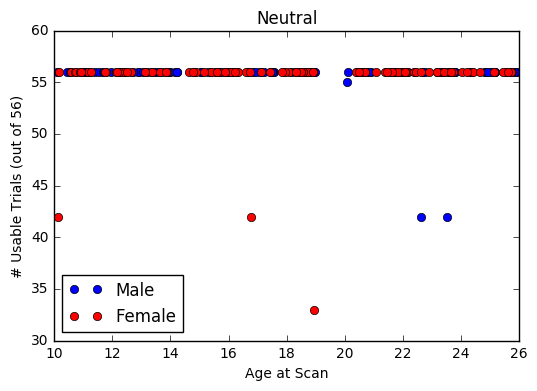

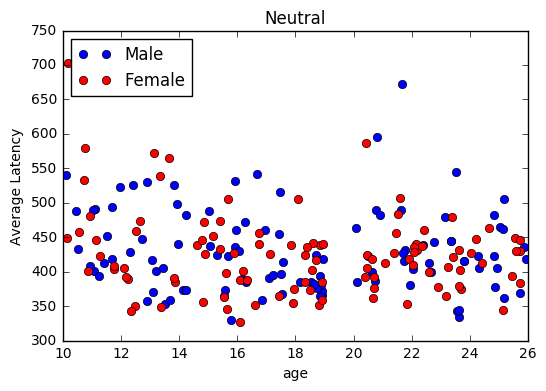

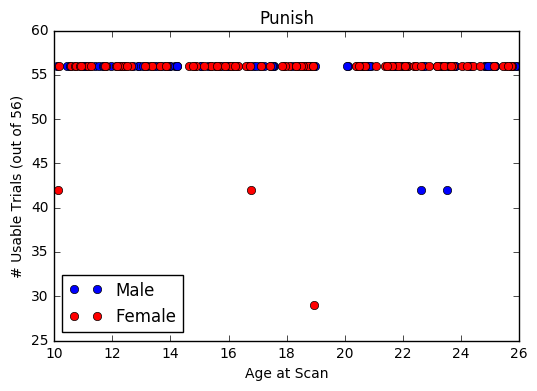

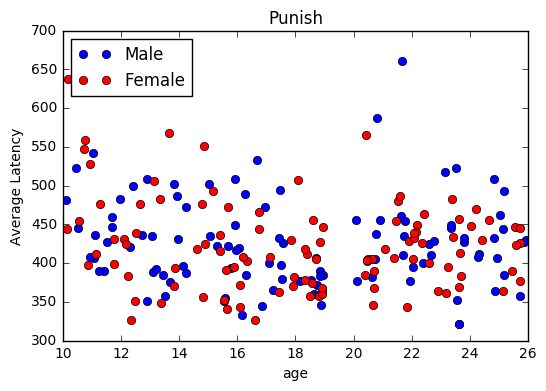

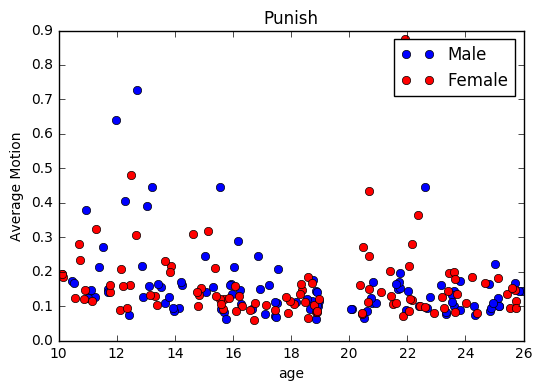

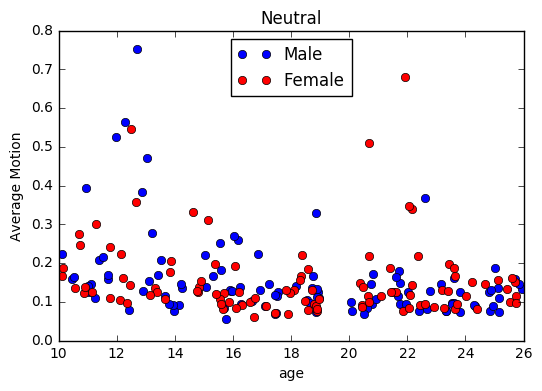

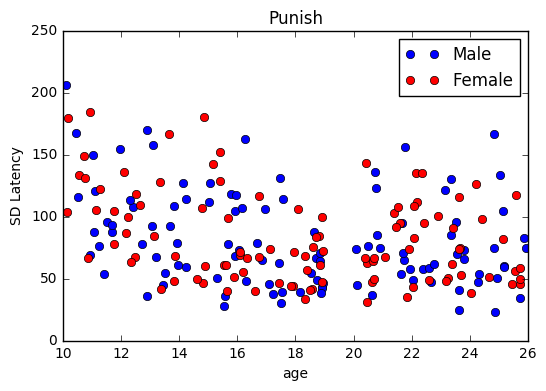

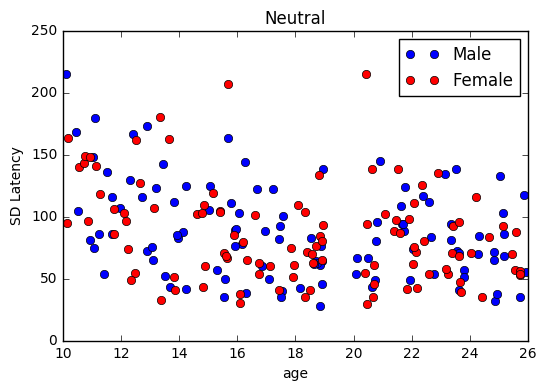

In [28]:
import matplotlib.pyplot as plt 
from pandas import DataFrame, Series,read_csv
analysis_home = '/Users/catcamacho/Box/LNCD_rewards_connectivity'
subject_info = read_csv(analysis_home + '/doc/fullsample_means.csv', index_col=0)


males = subject_info[subject_info.loc[:,'Male']==1]
females = subject_info[subject_info.loc[:,'Male']==0]

plt.plot(males['age'].tolist(),males['num_use_neut'].tolist(),'bo', label='Male')
plt.plot(females['age'].tolist(),females['num_use_neut'].tolist(),'ro', label='Female')
plt.legend(loc='best')
plt.xlabel('Age at Scan')
plt.ylabel('# Usable Trials (out of 56)')
plt.title('Neutral')
plt.savefig('neutral_trials.svg')
plt.show()

plt.plot(males['age'].tolist(),males['mean_lat_neut'].tolist(),'bo', label='Male')
plt.plot(females['age'].tolist(),females['mean_lat_neut'].tolist(),'ro', label='Female')
plt.legend(loc='best')
plt.xlabel('age')
plt.ylabel('Average Latency')
plt.title('Neutral')
plt.savefig('neutral_lat.svg')
plt.show()

plt.plot(males['age'].tolist(),males['num_use_pun'].tolist(),'bo', label='Male')
plt.plot(females['age'].tolist(),females['num_use_pun'].tolist(),'ro', label='Female')
plt.legend(loc='best')
plt.xlabel('Age at Scan')
plt.ylabel('# Usable Trials (out of 56)')
plt.title('Punish')
plt.savefig('punish_trials.svg')
plt.show()

plt.plot(males['age'].tolist(),males['mean_lat_pun'].tolist(),'bo', label='Male')
plt.plot(females['age'].tolist(),females['mean_lat_pun'].tolist(),'ro', label='Female')
plt.legend(loc='best')
plt.xlabel('age')
plt.ylabel('Average Latency')
plt.title('Punish')
plt.savefig('punish_lat.svg')
plt.show()

plt.plot(males['age'].tolist(),males['mot_pun'].tolist(),'bo', label='Male')
plt.plot(females['age'].tolist(),females['mot_pun'].tolist(),'ro', label='Female')
plt.legend(loc='best')
plt.xlabel('age')
plt.ylabel('Average Motion')
plt.title('Punish')
plt.savefig('punish_motion.svg')
plt.show()

plt.plot(males['age'].tolist(),males['mot_neut'].tolist(),'bo', label='Male')
plt.plot(females['age'].tolist(),females['mot_neut'].tolist(),'ro', label='Female')
plt.legend(loc='best')
plt.xlabel('age')
plt.ylabel('Average Motion')
plt.title('Neutral')
plt.savefig('neutral_motion.svg')
plt.show()

plt.plot(males['age'].tolist(),males['std_lat_pun'].tolist(),'bo', label='Male')
plt.plot(females['age'].tolist(),females['std_lat_pun'].tolist(),'ro', label='Female')
plt.legend(loc='best')
plt.xlabel('age')
plt.ylabel('SD Latency')
plt.title('Punish')
plt.savefig('punish_lat_std.svg')
plt.show()

plt.plot(males['age'].tolist(),males['std_lat_neut'].tolist(),'bo', label='Male')
plt.plot(females['age'].tolist(),females['std_lat_neut'].tolist(),'ro', label='Female')
plt.legend(loc='best')
plt.xlabel('age')
plt.ylabel('SD Latency')
plt.title('Neutral')
plt.savefig('neutral_lat_std.svg')
plt.show()


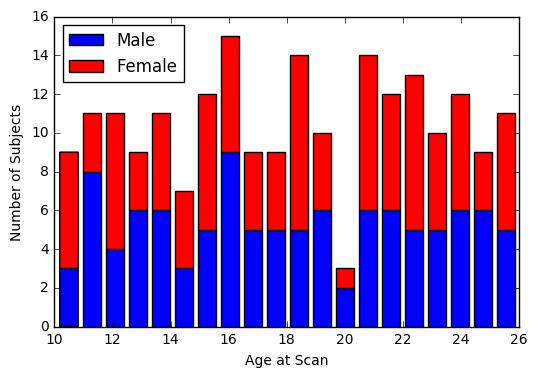

In [2]:
import matplotlib.pyplot as plt 
from pandas import DataFrame, Series,read_excel
analysis_home = '/Users/catcamacho/Box/LNCD_rewards_connectivity'
subject_info = read_excel(analysis_home + '/doc/groupsworksheet.xlsx')

males = subject_info[subject_info.loc[:,'Male']==1]
females = subject_info[subject_info.loc[:,'Female']==1]
male_age = males['age'].tolist()
female_age = females['age'].tolist()

fig1 = plt.hist([male_age, female_age], bins=20, stacked=True, align='mid', color=['blue','red'], label=['Male','Female'])
plt.xlabel('Age at Scan')
plt.ylabel('Number of Subjects')
plt.legend(loc='best')
plt.savefig('agehist.svg')
plt.show()


In [27]:
from pandas import DataFrame, Series,read_csv
import statsmodels.formula.api as smf
from sys import stdout

analysis_home = '/Users/catcamacho/Box/LNCD_rewards_connectivity'
data = read_csv(analysis_home + '/doc/fullsample_means.csv', index_col=None)

independent_variables = ['age','ageInv','ageSq','Male']
dependent_variables = data.columns.values.tolist()[7:]
#remove hm from dv list
dependent_variables = [x for x in dependent_variables if 'hm_' not in x]

print('First the linear Age Models')
for a in dependent_variables:
    model = smf.mixedlm('%s ~ age + Male + age*Male' % (a), data, groups=data['timepoint'])
    fitmodel = model.fit()
    print(fitmodel.summary())

print('Next are the Inverse Age Models')
for a in dependent_variables:
    model = smf.mixedlm('%s ~ ageInv + Male + ageInv*Male' % (a), data, groups=data['timepoint'])
    fitmodel = model.fit()
    print(fitmodel.summary())
    


First the linear Age Models
           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: num_use_total
No. Observations: 211     Method:             REML         
No. Groups:       1       Scale:              57.0329      
Min. group size:  211     Likelihood:         -724.5838    
Max. group size:  211     Converged:          Yes          
Mean group size:  211.0                                    
-----------------------------------------------------------
               Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     163.558    8.151 20.065 0.000 147.582 179.535
age             0.162    0.164  0.992 0.321  -0.158   0.483
Male            7.037    4.275  1.646 0.100  -1.342  15.417
age:Male       -0.350    0.229 -1.533 0.125  -0.798   0.098
groups RE      57.033                                      

          Mixed Linear Model Regression Results
Model:            MixedLM Dependen

/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mean_lat_pun
No. Observations: 211     Method:             REML        
No. Groups:       1       Scale:              3245.8693   
Min. group size:  211     Likelihood:         -1142.8800  
Max. group size:  211     Converged:          Yes         
Mean group size:  211.0                                   
----------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    465.864   61.495  7.576 0.000 345.336 586.392
age           -2.393    1.234 -1.938 0.053  -4.812   0.027
Male         -26.093   32.252 -0.809 0.418 -89.307  37.120
age:Male       1.542    1.724  0.894 0.371  -1.837   4.921
groups RE   3245.869                                      

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: std_lat_pun
No. Observations: 

/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWar

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: acc_neut
No. Observations: 211     Method:             REML    
No. Groups:       1       Scale:              0.0051  
Min. group size:  211     Likelihood:         239.8476
Max. group size:  211     Converged:          Yes     
Mean group size:  211.0                               
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.850    0.077 11.010 0.000  0.699  1.002
age          0.005    0.002  2.938 0.003  0.002  0.008
Male        -0.029    0.041 -0.704 0.481 -0.108  0.051
age:Male     0.001    0.002  0.452 0.651 -0.003  0.005
groups RE    0.005                                    

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: lm_num_use_total
No. Observations: 211     Method:             REML            
No. G

/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: lm_mean_lat_pun
No. Observations: 211     Method:             REML           
No. Groups:       1       Scale:              3253.2580      
Min. group size:  211     Likelihood:         -1143.1153     
Max. group size:  211     Converged:          Yes            
Mean group size:  211.0                                      
--------------------------------------------------------------
            Coef.    Std.Err.    z     P>|z|   [0.025   0.975]
--------------------------------------------------------------
Intercept   465.792    61.565   7.566  0.000  345.127  586.456
age          -2.383     1.236  -1.928  0.054   -4.804    0.039
Male        -24.975    32.289  -0.773  0.439  -88.261   38.310
age:Male      1.489     1.726   0.863  0.388   -1.894    4.872
groups RE  3253.258                                           

            Mixed Linear Model Regression Results
Model:            Mixed

/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model

            Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  mean_lat_pun
No. Observations:  211      Method:              REML        
No. Groups:        1        Scale:               3179.4016   
Min. group size:   211      Likelihood:          -1129.4708  
Max. group size:   211      Converged:           Yes         
Mean group size:   211.0                                     
-------------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------
Intercept    368.464   60.046  6.136 0.000   250.776  486.153
ageInv       915.128  338.150  2.706 0.007   252.366 1577.890
Male          32.714   29.244  1.119 0.263   -24.604   90.032
ageInv:Male -523.843  477.273 -1.098 0.272 -1459.282  411.596
groups RE   3179.402                                         

            Mixed Linear Model Regression Results
Model:             MixedLM  Dep

/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWar

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: lm_num_use_total
No. Observations: 211     Method:             REML            
No. Groups:       1       Scale:              98.8919         
Min. group size:  211     Likelihood:         -770.2822       
Max. group size:  211     Converged:          Yes             
Mean group size:  211.0                                       
--------------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z|  [0.025   0.975]
--------------------------------------------------------------
Intercept       168.854   10.590 15.945 0.000  148.098 189.610
ageInv          -71.969   59.637 -1.207 0.228 -188.856  44.918
Male              1.103    5.158  0.214 0.831   -9.006  11.211
ageInv:Male     -20.662   84.173 -0.245 0.806 -185.639 144.315
groups RE        98.892                                       

            Mixed Linear Model Regression Results
Model:          

/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: lm_mean_lat_pun
No. Observations: 211     Method:             REML           
No. Groups:       1       Scale:              3186.5287      
Min. group size:  211     Likelihood:         -1129.7025     
Max. group size:  211     Converged:          Yes            
Mean group size:  211.0                                      
-------------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------
Intercept    368.871   60.114  6.136 0.000   251.050  486.691
ageInv       910.104  338.529  2.688 0.007   246.600 1573.608
Male          31.588   29.277  1.079 0.281   -25.794   88.970
ageInv:Male -502.111  477.808 -1.051 0.293 -1438.597  434.376
groups RE   3186.529                                         

            Mixed Linear Model Regression Results
Model:            MixedLM Depen

/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2039: ConvergenceWarning: The Hessian matrix

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: lm_acc_neut
No. Observations: 211     Method:             REML       
No. Groups:       1       Scale:              0.0049     
Min. group size:  211     Likelihood:         255.4553   
Max. group size:  211     Converged:          Yes        
Mean group size:  211.0                                  
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       1.010    0.075 13.540 0.000  0.864  1.157
ageInv         -1.298    0.420 -3.088 0.002 -2.121 -0.474
Male            0.013    0.036  0.370 0.711 -0.058  0.085
ageInv:Male    -0.417    0.593 -0.702 0.482 -1.579  0.746
groups RE       0.005                                    

